# 요약
0. 먼저 데이터를 쪼개줘야함
    - 트레이닝 데이터와 테스트 데이터 7대3 혹은 8대2로 나눠서 학습용 데이터와 테스트하는 데이터를 나눈다
    - 범주형 값을 나누기위해서는 Pandas의 getdummie?를 사용할 수 도 있지만 tensorflow에서 one_hot 인코딩을 사용해서 쉽게 바꿀 수 있다(아래 mnist 예)
        - mnist = input_data.read_data_sets("./data/mnist", one_hot =True)
1. 데이터 전처리 과정을 거쳐야한다
    - 하지만 여기선 Nan값이라든가 다른 정규화가 필요하지 않기 때문에 생략한다
2. 학습모델
    - 데이터를 학습시키기위한 모델을 만드는데 여기서는 CNN + MLP를 통해 학습시켰다
    - CNN을 통해 숫자 이미지로부터 특징을 추출하고, 마지막으로 숫자이미지를 펼쳐서 1차원의 데이터로 바꾸고 input으로 넘겨줌
    - MLP를 통해 분류함
    - GPU환경에서 학습시키기때문에 메모리문제로 batch_size를 100으로 주고 학습시킴
3. 앙상블
    - 여러 모델들을 만들고 학습된 각 모델들에 대해 test하고싶은 데이터를 feed_dict으로 넣어주고 각 Hypothesis를 모두 더해주고 tf.argmax를 통해 좀 더 정교한 정확률을 얻을 수 있다
        - A B C D E 모델 중 A B C 는 3이라고 하고 D E는 4라고하면 3이 더 맞다고 봄
4. 추가 - 학습모델 클래스화 
    - 클래스의 구조
        1. 먼저 모델을 빌드(텐서 그래프를 그린다)
        2. 트레이닝(인자로 데이터셋을 받아서 학습시키도록 함, batch_size를 주고 학습)
        3. 예측(테스트 데이터셋을 받아서 학습된 모델을 통해 예측하고 정확률을 측정)
        4. 모델의 H를 받는다(학습된 모델객체에 대해서 특정 데이터(test)를 feed_dict으로 주고 H(예측값)를 뽑아봄)
            - 각 모델들의 H(tf.argmax하기 전 예측값)을 모두 더하고 argmax를 하면 모든 모델을 고려해서 값을 추정하기 때문에 랜덤을 기반으로 weight가 수정되는 모델들의 한계를 조금이나마 극복할 수 있음
            - 보통 2~5% 증가함
            - test data set에 기반되는 H와 label 값을 비교해서 정확율 측정 가능
5. 결과물 파일만들기
    - pd.to_csv(file_path, sep = ",", index = False)

6. 보완
    - cnn을 구성하는 노드들을 직접 그리는거보다 tf.layers 사용하면 쉽게 설계
        - tf.layers.conv2d(inputs, filters, kernel_size, padding, strides(non (),[]), activate)
        - tf.layers.max_pooling2d(inputs, pool_size(non 4d) = [2,2],  padding, strides(non (), []))
        - tf.layers.dropout(inputs, rate)
        - 마지막엔 reshape 해줘서 펼쳐준다 tf.reshape(input, shape(4d shape))
    - fully connected nn대신 tf.layers.dense 사용해 쉽게 설계
        - tf.layers.dense(inputs, units, activation)
            - units 뻗어나가는 줄기
        - tf.layers.dropout(inputs, rate)
        - 마지막으로 Weight bias가 명시되어있지 않은 Hypothesis는
            - tf.layers.dense(inputs, uints = output) 
                - matmul만 하게 되는 logit 생각하면 됨
            

### ensemble(앙상블)
- 모델이 여러개
- 각각의 모델을 학습시킴
- 각 모델에 입력 parameter(이미지 픽셀)을 넣어서 예측값을 알아냄

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

train_csv = pd.read_csv("./data/mnist/train.csv")
n = int(train_csv.shape[0] * 0.8)
test_csv = train_csv.loc[n:, :]
train_csv = train_csv.loc[:n-1, :]
real_test_csv = pd.read_csv("./data/mnist/test.csv")



### 0. 전처리
- 데이터를 test/train으로 나눠준다

### 1. NN학습
- CNN으로 학습
- xaviers init
- dropout
- adam optimzer

### 2. batch / epoch 나눠서 학습


In [2]:
# real data
x_real_test_data = real_test_csv

x_train_data.shape : (33600, 784), y_train_data.shape : (33600, 10)
x_test_data.shape : (8400, 784), y_test_data.shape : (8400, 10)


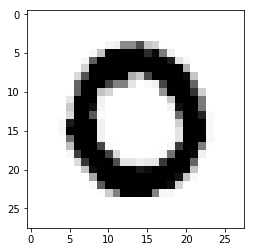

In [3]:
x_train_data = train_csv.drop("label", axis = 1)
y_train_data = pd.get_dummies(train_csv["label"])

x_test_data = test_csv.drop("label", axis = 1)
y_test_data = pd.get_dummies(test_csv["label"])

print("x_train_data.shape : {}, y_train_data.shape : {}".format(x_train_data.shape,y_train_data.shape))
print("x_test_data.shape : {}, y_test_data.shape : {}".format(x_test_data.shape,y_test_data.shape))

img = (x_train_data.loc[1,:].values).reshape(28,28)
# 0번째 행의 숫자 그려보기 
plt.imshow(img, cmap="Greys")
plt.show()

In [4]:
x_test_data = pd.DataFrame(x_test_data.values, columns=x_test_data.columns)
y_test_data = pd.DataFrame(y_test_data.values, columns=y_test_data.columns)

In [5]:
def set_weight(w_name, w_shape):
    return tf.get_variable(name =w_name, shape = w_shape,initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)

def set_bias(b_name, b_shape):
    return tf.Variable(tf.random_normal(b_shape), name = b_name, dtype =tf.float32)

def get_total_n(data, batch_size):
    return int(data.shape[0] / batch_size)


### class화

In [6]:

import math 

class CNNModel:
    def __init__(self,sess, name):
        self.name = name 
        self.sess = sess
        
    # tensorflow graph 구현부분
    def create_network(self,input_x,input_y):
        with tf.variable_scope(self.name):
            self.X = tf.placeholder(shape = [None, input_x], dtype = tf.float32)
            self.Y = tf.placeholder(shape = [None, input_y], dtype = tf.float32)
            self.keep_rate = tf.placeholder(dtype= tf.float32)
            
            X_img = tf.reshape(self.X, shape = [-1, int(math.sqrt(input_x)), int(math.sqrt(input_x)), 1])

#             W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
#             L1 = tf.nn.conv2d(X_img, W1, strides = [1,1,1,1], padding = "SAME")

#             L1 = tf.nn.relu(L1)
#             L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

#             W2 = set_weight("weight2", [3,3,32,64])
#             L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
#             L2 = tf.nn.relu(L2)
#             L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
            L1 = tf.layers.conv2d(inputs = X_img, filters = 32, kernel_size =[3,3],
                            padding = "SAME", strides = 1,activation = tf.nn.relu)
            L1 = tf.layers.max_pooling2d(inputs = L1, pool_size = [2,2], padding ="SAME", strides = 2)
            L1 = tf.layers.dropout(inputs=L1, rate =self.keep_rate)
            
            L2 = tf.layers.conv2d(inputs = L1, filters = 64, kernel_size =[3,3],
                            padding = "SAME", strides = 1,activation = tf.nn.relu)
            L2 = tf.layers.max_pooling2d(inputs = L2, pool_size = [2,2], padding ="SAME", strides = 2)
            L2 = tf.layers.dropout(inputs=L2, rate =self.keep_rate)
            
            L3 = tf.layers.conv2d(inputs = L2, filters = 128, kernel_size =[3,3],
                            padding = "SAME", strides = 1,activation = tf.nn.relu)
            L3 = tf.layers.max_pooling2d(inputs = L3, pool_size = [2,2], padding ="SAME", strides = 2)
            L3 = tf.layers.dropout(inputs=L3, rate =self.keep_rate)
            L3 = tf.reshape(L3, shape=[-1,4*4*128])
            #(4*4*128)
        
            ## cnn layer 3 , dense 5
            # dense layer
            # dense1 = tf.layers.dense(inputs=L3, uints=128, activation = tf.nn.relu)
            # dense1 = tf.layers.dropout(inputs=dense1, rate = self.keep_prob)
            # self.H = tf.layers.dense(inputs=desnse5, uints=10)
#             FC = tf.reshape(L2, shape=[-1, 7*7*64])

#             FC_W1 = set_weight("fc_weight1", [7*7*64, 256])
#             FC_b1 = set_bias( "fc_bias1", [256])
#             _FC_L1 = tf.nn.relu(tf.matmul(FC,FC_W1) + FC_b1)
#             FC_L1 = tf.nn.dropout(_FC_L1, keep_prob = self.keep_rate) 

#             FC_W2 = set_weight("fc_weight2", [256, 256])
#             FC_b2 = set_bias( "fc_bias2", [256])
#             _FC_L2 = tf.nn.relu(tf.matmul(FC_L1,FC_W2) + FC_b2)
#             FC_L2 = tf.nn.dropout(_FC_L2, keep_prob = self.keep_rate) 


#             FC_W3 = set_weight("fc_weight3", [256, 10])
#             FC_b3 = set_bias( "fc_bias3", [10])
            dense1 = tf.layers.dense(inputs = L3, units = 128, activation= tf.nn.relu)
            dense1 = tf.layers.dropout(inputs=dense1, rate = self.keep_rate)
        
            dense2 = tf.layers.dense(inputs = dense1, units = 256, activation= tf.nn.relu)
            dense2 = tf.layers.dropout(inputs=dense2, rate = self.keep_rate)
            
            dense3 = tf.layers.dense(inputs = dense2, units = 128, activation= tf.nn.relu)
            dense3 = tf.layers.dropout(inputs=dense3, rate = self.keep_rate)
            
            dense4 = tf.layers.dense(inputs = dense3, units = 512, activation= tf.nn.relu)
            dense4 = tf.layers.dropout(inputs=dense4, rate = self.keep_rate)
            
            dense5 = tf.layers.dense(inputs = dense4, units = 1024, activation= tf.nn.relu)
            dense5 = tf.layers.dropout(inputs=dense5, rate = self.keep_rate)
            
            self.H = tf.layers.dense(inputs=dense5, units = 10)
#             self.logit = tf.matmul(FC_L2, FC_W3) + FC_b3
#             self.H = tf.nn.softmax(self.logit)
            self.cost = tf.losses.softmax_cross_entropy(self.Y, self.H)
            #self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logit, labels = self.Y))
            optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.train = optimizer.minimize(self.cost)
            
            self.sess.run(tf.global_variables_initializer())
    # batch size로 트레이닝
    def batch_train(self,epoch_size, batch_size, features, label):
        iter_of_num = int(features.shape[0] / batch_size)
        for ep in range(epoch_size):
            batch_start = 0
            for i in range(iter_of_num):
                batch_end = batch_start + batch_size
                # 마지막 iteration에서는 100개가 딱 안맞을수도 있음
                if i == iter_of_num-1:
                    x_batch = features.loc[batch_start:, :]
                    y_batch = label.loc[batch_start:, :]
                    _, self.cost_val = self.sess.run([self.train, self.cost], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.5})
                else:
                    x_batch = features.loc[batch_start:batch_end-1, :]
                    y_batch = label.loc[batch_start:batch_end-1, :]
                    _, self.cost_val = self.sess.run([self.train, self.cost], feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:0.5})
                    batch_start = batch_end
            if ep % 7 == 0:
                print("cost_val : {}".format(self.cost_val))
    # batch size로 accuracy 측정
    def batch_accuracy(self, batch_size, features, label):
        predict = tf.argmax(self.H, axis = 1)
        correct = tf.equal(predict, tf.argmax(self.Y, axis = 1))
        accuracy = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))
        
        iter_of_num = int(features.shape[0] / batch_size)
        
        result = 0
        batch_start = 0
        for i in range(iter_of_num):
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                x_batch = features.loc[batch_start:,:]
                y_batch = label.loc[batch_start:,:]
                accuracy_batch = self.sess.run(accuracy, feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:1.0})
                
            else:
                x_batch = features.loc[batch_start:batch_end-1,:]
                y_batch = label.loc[batch_start:batch_end-1,:]
                batch_start = batch_end
                accuracy_batch = self.sess.run(accuracy, feed_dict={self.X:x_batch, self.Y:y_batch, self.keep_rate:1.0})
                
            result += accuracy_batch
        return (result/features.shape[0])

    #batch size로 예측
    def batch_predict(self, batch_size, features):
        predict = tf.argmax(self.H, axis = 1)
        
        iter_of_num = int(features.shape[0] / batch_size)
        
        predict_list = []
        result = []
        batch_start = 0
        for i in range(iter_of_num):
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                x_batch = features.loc[batch_start:, :]
                predict_list = self.sess.run(predict, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            else:
                x_batch = features.loc[batch_start:batch_end-1, :]
                batch_start = batch_end
                predict_list = self.sess.run(predict, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            for i in predict_list:
                result.append(i)
        return result
        
    def get_hypothesis(self, batch_size, features):
        iter_of_num = int(features.shape[0] / batch_size)
        hypo_np = np.zeros([1,10])
        batch_start = 0
        for i in range(iter_of_num):
            batch_end = batch_start + batch_size
            if i == iter_of_num-1:
                x_batch = features.loc[batch_start:, :]
                hypo = self.sess.run(self.H, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            else:
                x_batch = features.loc[batch_start:batch_end-1, :]
                batch_start = batch_end
                hypo = self.sess.run(self.H, feed_dict={self.X:x_batch, self.keep_rate:1.0})
            hypo_np = np.append(hypo_np, hypo,axis=0)
        return hypo_np

In [7]:
tf.reset_default_graph()

In [8]:
cnn_list = []
sess= tf.Session()

for i in range(20):
    cnnmodel = CNNModel(sess, "cnn_"+str(i))
    cnnmodel.create_network(784,10)
    cnn_list.append(cnnmodel)


In [9]:
%%time
for d,cnn in enumerate(cnn_list):
    print("cnn_{} training".format(d))
    cnn.batch_train(21, 100, x_train_data, y_train_data)

cnn_0 training
cost_val : 0.1508096158504486
cost_val : 0.03352919965982437
cost_val : 0.0018986238865181804
cnn_1 training
cost_val : 0.1512259840965271
cost_val : 0.00397790502756834
cost_val : 0.015249954536557198
cnn_2 training
cost_val : 0.10291532427072525
cost_val : 0.010494410060346127
cost_val : 0.0015798562671989202
cnn_3 training
cost_val : 0.1334151327610016
cost_val : 0.00871839839965105
cost_val : 0.0005476073129102588
cnn_4 training
cost_val : 0.1563984900712967
cost_val : 0.008216735906898975
cost_val : 0.0011433404870331287
cnn_5 training
cost_val : 0.14909470081329346
cost_val : 0.0259462371468544
cost_val : 0.018597997725009918
cnn_6 training
cost_val : 0.14156758785247803
cost_val : 0.038591548800468445
cost_val : 0.006037499289959669
cnn_7 training
cost_val : 0.17244695127010345
cost_val : 0.019390754401683807
cost_val : 9.177020547213033e-05
cnn_8 training
cost_val : 0.10917346179485321
cost_val : 0.003482620231807232
cost_val : 0.024602245539426804
cnn_9 training

In [10]:
for d,cnn in enumerate(cnn_list):
    print("cnn_{} accuracy : {}".format(d, cnn.batch_accuracy(100, x_test_data, y_test_data)))

cnn_0 accuracy : 0.9888095238095238
cnn_1 accuracy : 0.9866666666666667
cnn_2 accuracy : 0.9857142857142858
cnn_3 accuracy : 0.9890476190476191
cnn_4 accuracy : 0.9858333333333333
cnn_5 accuracy : 0.9872619047619048
cnn_6 accuracy : 0.9848809523809524
cnn_7 accuracy : 0.9885714285714285
cnn_8 accuracy : 0.9866666666666667
cnn_9 accuracy : 0.9877380952380952
cnn_10 accuracy : 0.981904761904762
cnn_11 accuracy : 0.9891666666666666
cnn_12 accuracy : 0.9833333333333333
cnn_13 accuracy : 0.9810714285714286
cnn_14 accuracy : 0.9882142857142857
cnn_15 accuracy : 0.9863095238095239
cnn_16 accuracy : 0.9878571428571429
cnn_17 accuracy : 0.9830952380952381
cnn_18 accuracy : 0.986904761904762
cnn_19 accuracy : 0.983452380952381


In [11]:
sum_hypo = 0
for cnn in cnn_list:
    # hypothesis를 더할떄 np.zero(10)에 append해줬기때문에 첫행 빼고 더해준다
    cnn_hypo = cnn.get_hypothesis(100, x_test_data)[1:]
    sum_hypo += cnn_hypo
print("sum_hypo.shape : {}".format(sum_hypo.shape))

sum_hypo.shape : (8400, 10)


In [12]:
ensemble_predict = sess.run(tf.argmax(sum_hypo, axis = 1))
print("ensemble_predict : {}".format(ensemble_predict.shape))

ensemble_predict : (8400,)


### ensemble accuracy

In [13]:
correct = tf.equal(ensemble_predict, tf.argmax(y_test_data, axis = 1))
predict = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))
accuracy = (sess.run(predict)/y_test_data.shape[0])
print(accuracy)

0.9925


### 최종적으로 예측할 data

In [14]:
sum_hypo = 0
for cnn in cnn_list:
    cnn_hypo = cnn.get_hypothesis(100, x_real_test_data)[1:]
    sum_hypo += cnn_hypo
print("sum_hypo.shape : {}".format(sum_hypo.shape))

sum_hypo.shape : (28000, 10)


In [15]:
final_predict = sess.run(tf.argmax(sum_hypo, axis =1))
print(final_predict.shape)


(28000,)


In [16]:
predict_df = pd.DataFrame(np.array(range(1,28001)).reshape([-1,1]), index = range(1,28001),columns=["ImageId"])
predict_df["Label"] = final_predict

predict_df.to_csv("./data/mnist/digit_pd.csv", sep = ',',index=False)

# 앙상블 전 99%

In [595]:
# tensorflow 초기화
tf.reset_default_graph()


# placeholder 
X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
keep_rate = tf.placeholder(dtype= tf.float32)

# input conv img
X_img = tf.reshape(X, shape = [-1, 28,28,1])

W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides = [1,1,1,1], padding="SAME")
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

W2 = set_weight("weight2", [3,3,32,64])
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
print(L2)
FC = tf.reshape(L2, shape=[-1, 7*7*64])

FC_W1 = set_weight("fc_weight1", [7*7*64, 256])
FC_b1 = set_bias( "fc_bias1", [256])
_FC_L1 = tf.nn.relu(tf.matmul(FC,FC_W1) + FC_b1)
FC_L1 = tf.nn.dropout(_FC_L1, keep_prob = keep_rate) 

FC_W2 = set_weight("fc_weight2", [256, 256])
FC_b2 = set_bias( "fc_bias2", [256])
_FC_L2 = tf.nn.relu(tf.matmul(FC_L1,FC_W2) + FC_b2)
FC_L2 = tf.nn.dropout(_FC_L2, keep_prob = keep_rate) 


FC_W3 = set_weight("fc_weight3", [256, 10])
FC_b3 = set_bias( "fc_bias3", [10])

logit = tf.matmul(FC_L2, FC_W3) + FC_b3
H = tf.nn.softmax(logit)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 1
batch_size = 100

# loc는 이상,이하로 범위 슬라이싱 
for step in range(train_epoch):
    num_of_iter = get_total_n(x_train_data, batch_size)
    batch_start = 0
    for i in range(num_of_iter):
        batch_next = batch_start + batch_size
        if i ==  num_of_iter-1:
            xtd = x_train_data.loc[batch_start:,:]
            ytd = y_train_data.loc[batch_start:,:]
            _, cost_val = sess.run([train,cost], feed_dict={X: xtd, Y: ytd, keep_rate: 0.7})
        else:
            xtd = x_train_data.loc[batch_start:batch_next-1,:]
            ytd = y_train_data.loc[batch_start:batch_next-1,:]
            _, cost_val = sess.run([train,cost], feed_dict={X: xtd, Y: ytd, keep_rate: 0.7})
            batch_start = batch_next
    if step % 5 == 0:
        print("cost_val : {}".format(cost_val))
           


Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
cost_val : 0.4273631274700165


In [596]:
x_test_data = pd.DataFrame(x_test_data.values, columns=x_test_data.columns)
y_test_data = pd.DataFrame(y_test_data.values, columns=y_test_data.columns)

In [598]:
predict = tf.argmax(H, axis = 1)

correct = tf.equal(predict, tf.argmax(Y, axis = 1))
accuracy = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))

num_iter = get_total_n(x_test_data, batch_size)
batch_start = 0
accuracy_sum = 0

for i in range(num_iter):
    batch_next = batch_start + batch_size
    if i ==  num_of_iter-1:
        xtd = x_test_data.loc[batch_start:,:]
        ytd = y_test_data.loc[batch_start:,:]
        batch_sum = sess.run(accuracy, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
    else:
        xtd = x_test_data.loc[batch_start:batch_next-1,:]
        ytd = y_test_data.loc[batch_start:batch_next-1,:]
        #print("xtd.shape : {}, ytd.shape : {}".format(xtd.shape, ytd.shape))
        batch_sum = sess.run(accuracy, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
        a = sess.run(predict, feed_dict={X: xtd, Y: ytd, keep_rate: 1.0})
        #print("batch_sum : {}, start : {}, end : {}".format(batch_sum,batch_start, batch_next))
        batch_start = batch_next
        
    accuracy_sum += batch_sum
print("accuracy : {}".format((accuracy_sum/x_test_data.shape[0])))
print(a.shape)

<class 'tensorflow.python.framework.ops.Tensor'>
accuracy : 0.9557142857142857
(100,)


### test data 예측

In [39]:
accuracy_list = []
result = []
num_iter = x_real_test_data.shape[0]
batch_size = 100
batch_start = 0
for i in range(num_iter):
    batch_next = batch_start + batch_size
    if i ==  num_of_iter-1:
        xtd = x_real_test_data.loc[batch_start:,:]
        ytd = x_real_test_data.loc[batch_start:,:]
        accuracy_list = sess.run(predict, feed_dict={X: xtd, keep_rate: 1.0})
    else:
        xtd = x_real_test_data.loc[batch_start:batch_next-1,:]
        ytd = x_real_test_data.loc[batch_start:batch_next-1,:]
        #print("xtd.shape : {}, ytd.shape : {}".format(xtd.shape, ytd.shape))
        accuracy_list = sess.run(predict, feed_dict={X: xtd, keep_rate: 1.0})
        #print("batch_sum : {}, start : {}, end : {}".format(batch_sum,batch_start, batch_next))
        batch_start = batch_next
    for r in accuracy_list:
        result.append(r)

In [40]:
df_predict = pd.DataFrame(result, columns = ["label"])
digit_predict = pd.concat([df_predict, x_real_test_data], axis = 1)
print(digit_predict.shape)
digit_predict.to_csv("digit_predict.csv", sep = ',',index=False)


(28000, 785)


In [41]:
data = pd.read_csv("./digit_predict.csv",sep=",")
label_ = data["label"]
ImageId_ = np.arange(1,28001)

In [42]:
digit_pd = pd.DataFrame(ImageId_,columns=["ImageId"])
digit_pd["Label"] = label_

In [43]:
digit_pd.to_csv("digit_pd.csv", sep = ',',index=False)